### MEDIA / NEW BIAS DETECTION 
**USING DEEP LEARNING AND TENSORFLOW**  
+ Using deep learning models to predic the presence of bias in news cast or media reports
+ Predicting political idealogies based on Right <-> Left political Spectrum. 

### DEFINATION OF TERMS:

**LEFT WING**  
- Generally,the left wing is characterised by an emphasis on "ideas such as freedeom, equity, fraternity, rights, progress reforms and internationalism".


#### WHILE 


**RIGHT WING**  
- Generally characterised ny an emphasis on "Notions such as authority, hierachy, order, duty, tradition, reaction and Nationalism.

#### Political scientist and other analyst regards the left wing to include :
     - communism / communist       - left libaterians 
     - socialist                   - progressive and social librals 
     - Democratic Socialist        - Movement for social equity 
     - Social Democrats            - Anarchists 
     
#### And Right to incude :
    - Conversationist 
    - Right Libertarians 
    - imperisalist 
    - Neo-Conservatives 
    - Anarcho - Capitalist

### Dataset & credit:
    -https://media-bias-research.org/publications/
    -https://github.com/Media-Bias-Group/Neural-Media-Bias-Detection-Using-Distant-Supervision-With-BABE/blob/main/annotator_demographics.csv

### Dependences

    EDA Packages                 ML Packages                            DL Packages
   
    - pandas                      - sklearn                             - TensorFlow
    - Numpy                       - LogisticRegression                  - Keras
    - Matplotlib                  - NaiveBayes 
    - Seaborn                     - DecisionTreeRegressor 

### Importing all the libraries 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import neattext as nfx
from wordcloud import WordCloud
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


In [2]:
print("Keras Version : {}".format(keras.__version__))

Keras Version : 2.10.0


In [3]:
sns.set()

### Exploratory data Analysis

In [4]:
# Loading the data set 

path = "final_labels_MBIC.csv"
data = pd.read_csv(path, sep=";")

In [5]:
data.head()

,text,news_link,outlet,topic,type,group_id,num_sent,label_bias,label_opinion,article,biased_words
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
2,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."
3,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,1,1,Biased,Expresses writer’s opinion,"In Barack Obama’s first term, the administrati...","['rejects', 'happy', 'assumed']"
4,The explosion of the Hispanic population has l...,https://www.breitbart.com/politics/2015/02/26/...,breitbart,student-debt,right,1,1,Biased,No agreement,"Republicans should stop fighting amnesty, Pres...",['explosion']


In [6]:
print(data.shape)

(1700, 11)


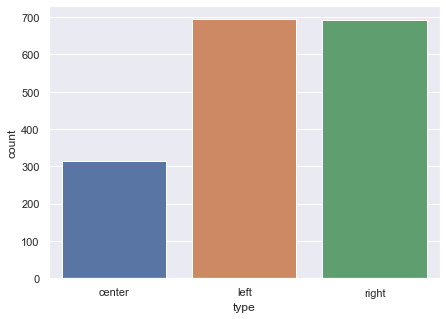

In [7]:
# Checking the Type Distribution 
# Left,Right,Center Political Wing

plt.figure(figsize=(7,5))
sns.countplot(data=data, x= "type")
plt.show()

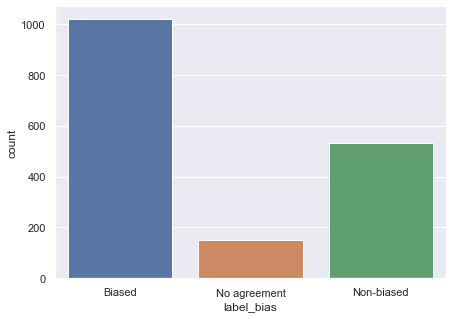

In [8]:
# Checking the Bias Distribution 


plt.figure(figsize=(7,5))
sns.countplot(data=data, x= "label_bias")
plt.show()

<Figure size 504x360 with 0 Axes>

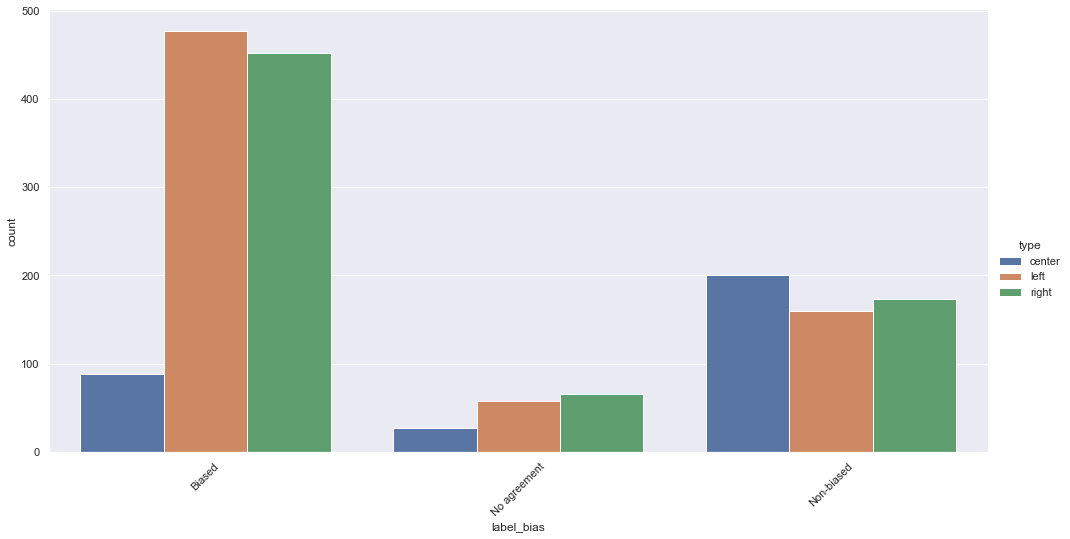

In [9]:
# Distribution of bias and type
plt.figure(figsize=(7,5))
sns.catplot(data=data,kind="count" ,x= "label_bias",hue="type",height=7,aspect=2)
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing 

In [10]:
data.isnull().sum()

text               0
news_link         19
outlet             0
topic              0
type               0
group_id           0
num_sent           0
label_bias         0
label_opinion      0
article          105
biased_words       0
dtype: int64

In [11]:
# fill the missing inputs with "Unknown" string

data = data.fillna("unknown")

In [12]:
data.isnull().sum()

text             0
news_link        0
outlet           0
topic            0
type             0
group_id         0
num_sent         0
label_bias       0
label_opinion    0
article          0
biased_words     0
dtype: int64

In [13]:
# Concatenate [text] and [article] columns 

data["news"] = data["text"] + data["article"]

In [14]:
data.columns

Index(['text', 'news_link', 'outlet', 'topic', 'type', 'group_id', 'num_sent',
       'label_bias', 'label_opinion', 'article', 'biased_words', 'news'],
      dtype='object')

### Text Cleaning 
    - remove stop words 
    - remove punctuation 
    - coverting text to lower case 
    

In [15]:
data["clean_text"] = data["news"].apply(nfx.remove_stopwords)
data["clean_text"] = data["clean_text"].apply(lambda x : nfx.remove_punctuations(x.lower()))

In [16]:
data["clean_text"][:5]

0    youtube making clear “birtherism” platform yea...
1    humanitarian crisis driving vulnerable people ...
2    looking united states welfare left stop killin...
3    republican president assumed helping industry ...
4    explosion hispanic population longterm job pro...
Name: clean_text, dtype: object

In [17]:
data["type"].unique().tolist()

['center', 'left', 'right']

In [18]:
# Converting each of the bias type in the text to a list  

center_list = data[data["type"] == "center"]["clean_text"].tolist()
left_list = data[data["type"] == "left"]["clean_text"].to_list()
right_list = data[data["type"] == "right"]["clean_text"].to_list()

In [19]:
# Defining Function

# Most common keyword

def keyword_extraction (text,num=50):
    token = [tok for tok in text.split()]
    most_common_keyword = Counter(token).most_common(num)
    return dict(most_common_keyword)


# function for Word Cloud plottig

def word_cloud (docx,wing):
    plt.figure(figsize=(20,10))
    mycloud = WordCloud().generate(docx)
    plt.title("Wordcloud plot for {}".format(wing))
    plt.imshow(mycloud, interpolation="bilinear")
    plt.axis("off")
    plt.show(block=True)
    

#function for plotting keywords 

def plot_most_common_word (mydict,wing):
    df = pd.DataFrame (mydict.items(),columns=["token","count"])
    plt.figure(figsize=(20,10))
    plt.title("Plot of {} most common word".format(wing))
    sns.barplot(x="token", y="count", data = df)
    plt.xticks(rotation = 45)
    plt.show()
    
    
# function for joinning all the words in the label biases 

def docx (bias_list):
    bias_docx = ' '.join(bias_list)
    return bias_docx

### Plotings
- most common words 
- Wordcloud
- For each Wing (Right,Left,Center)

In [20]:
# Label Bias

center_label = docx(center_list) 
left_label = docx(left_list)
right_label = docx(right_list)

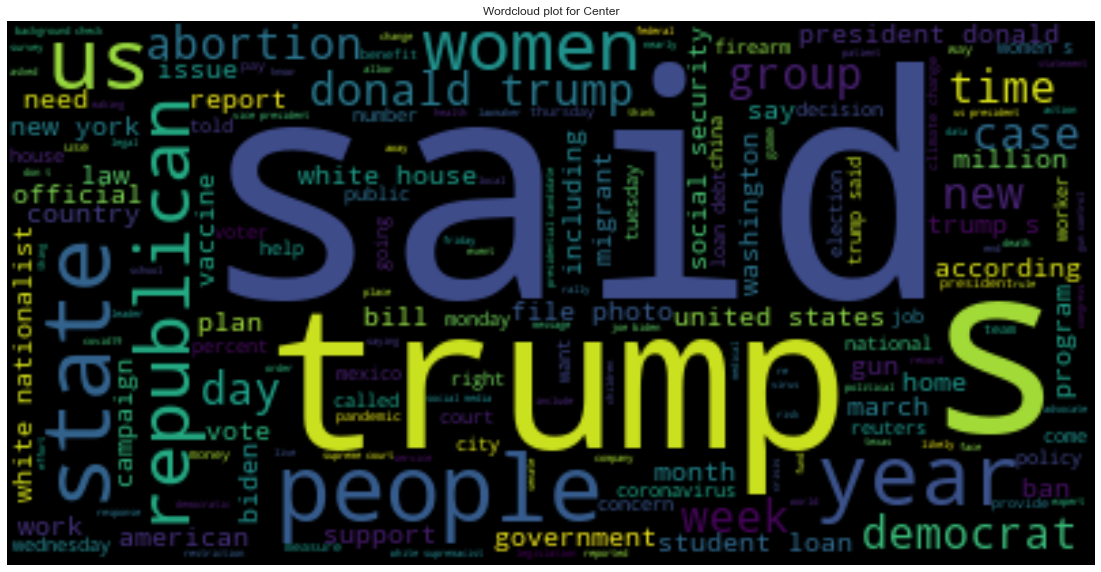

In [21]:
word_cloud(center_label,"Center")

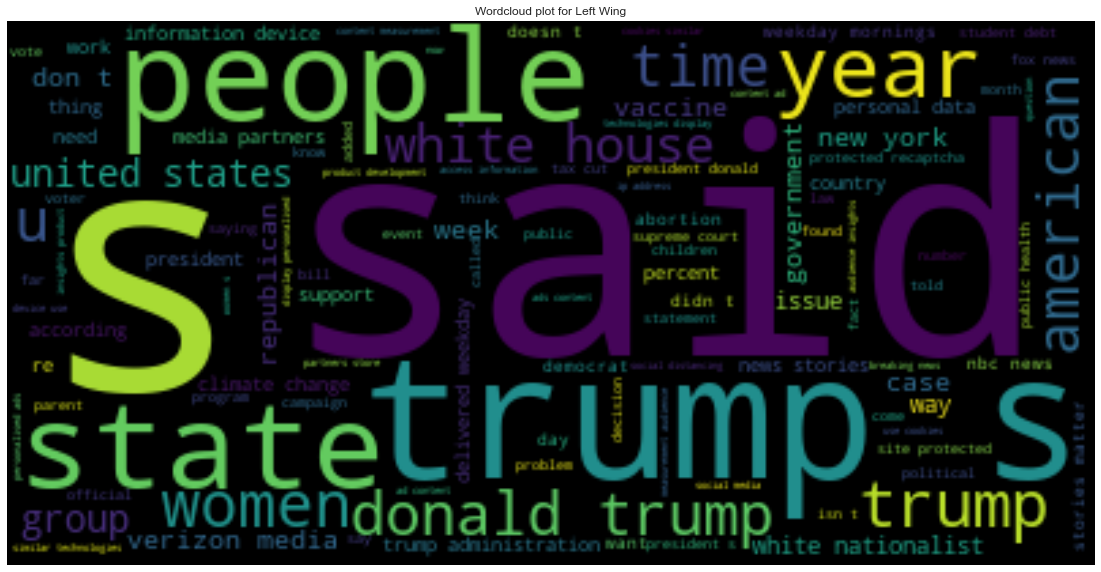

In [22]:
word_cloud(left_label,"Left Wing")

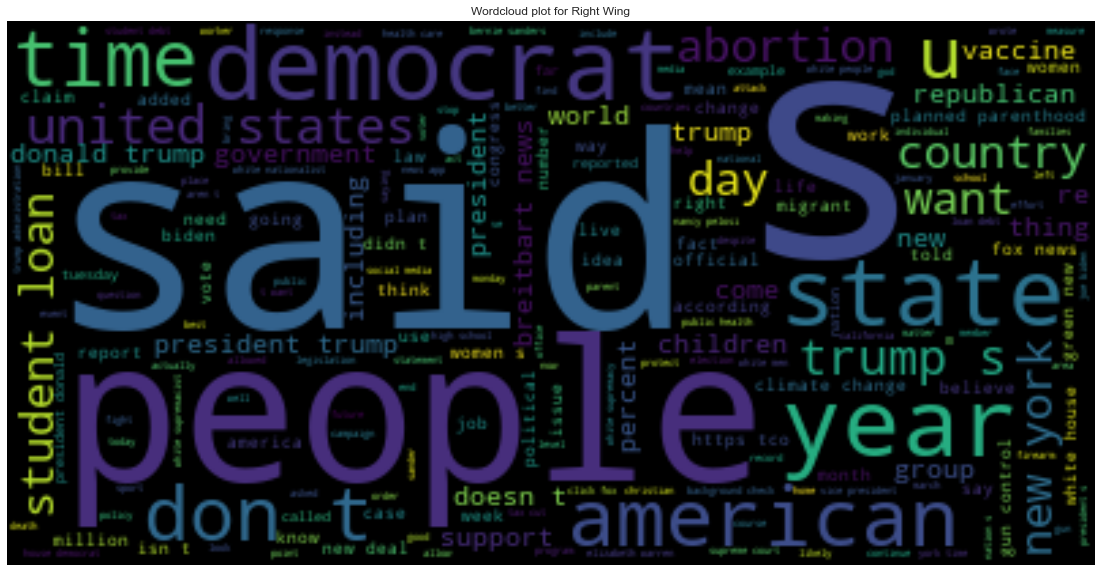

In [23]:
word_cloud(right_label,"Right Wing")

In [24]:
center_kw = keyword_extraction(center_label)
left_kw   = keyword_extraction(left_label)
right_kw  = keyword_extraction(right_label)

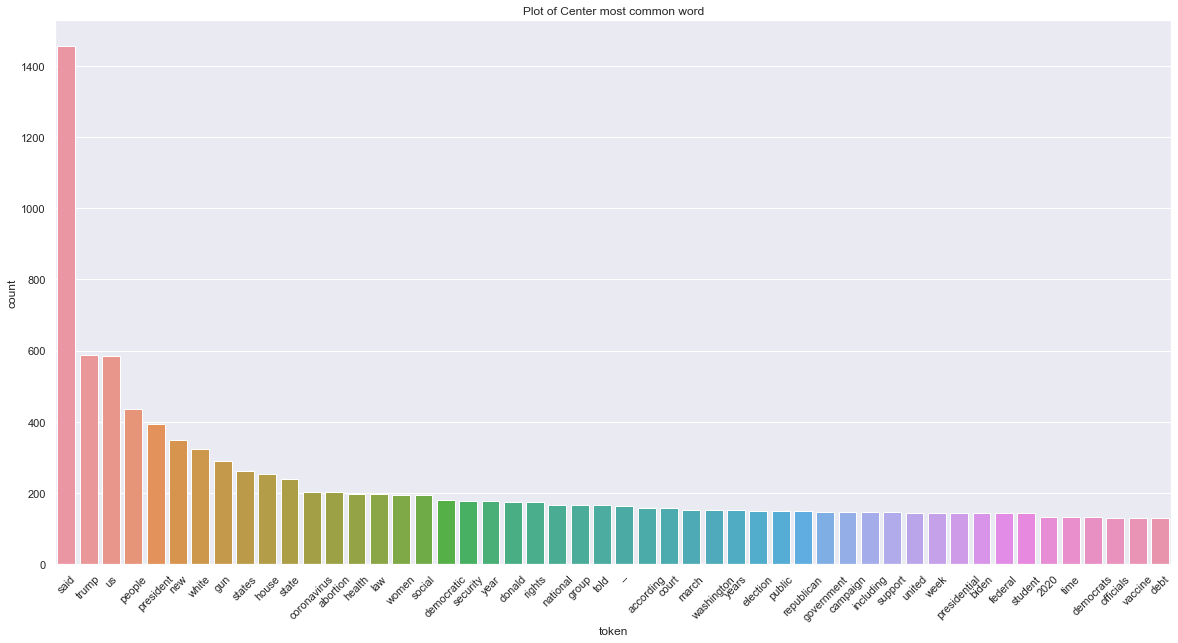

In [25]:
plot_most_common_word(center_kw,"Center")

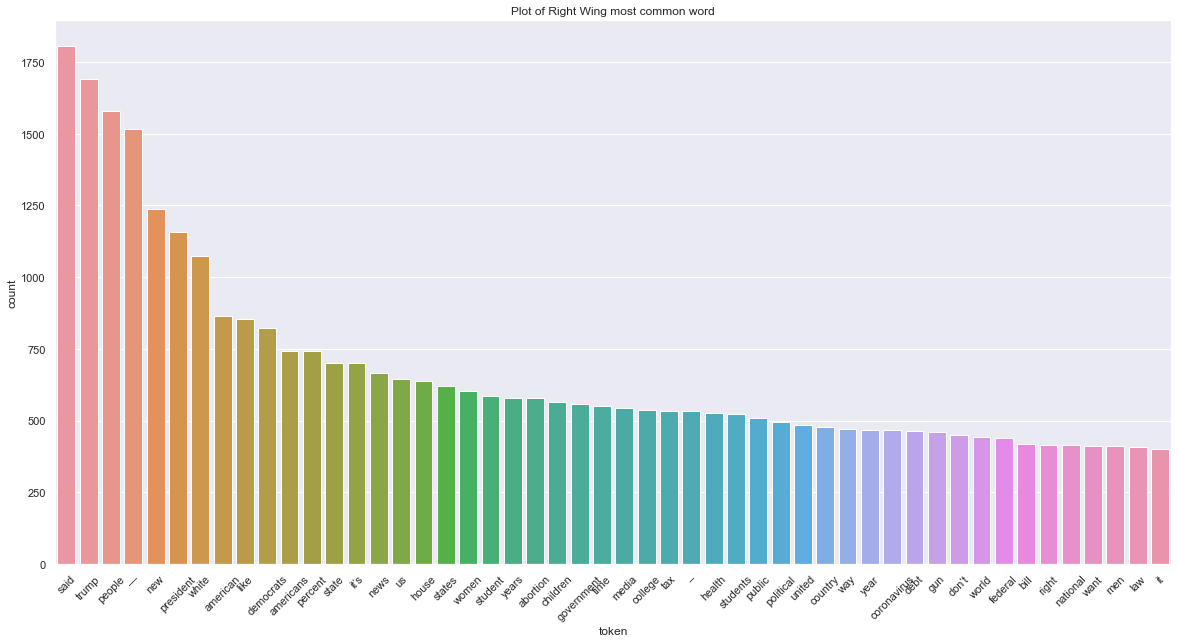

In [26]:
plot_most_common_word(right_kw,"Right Wing")

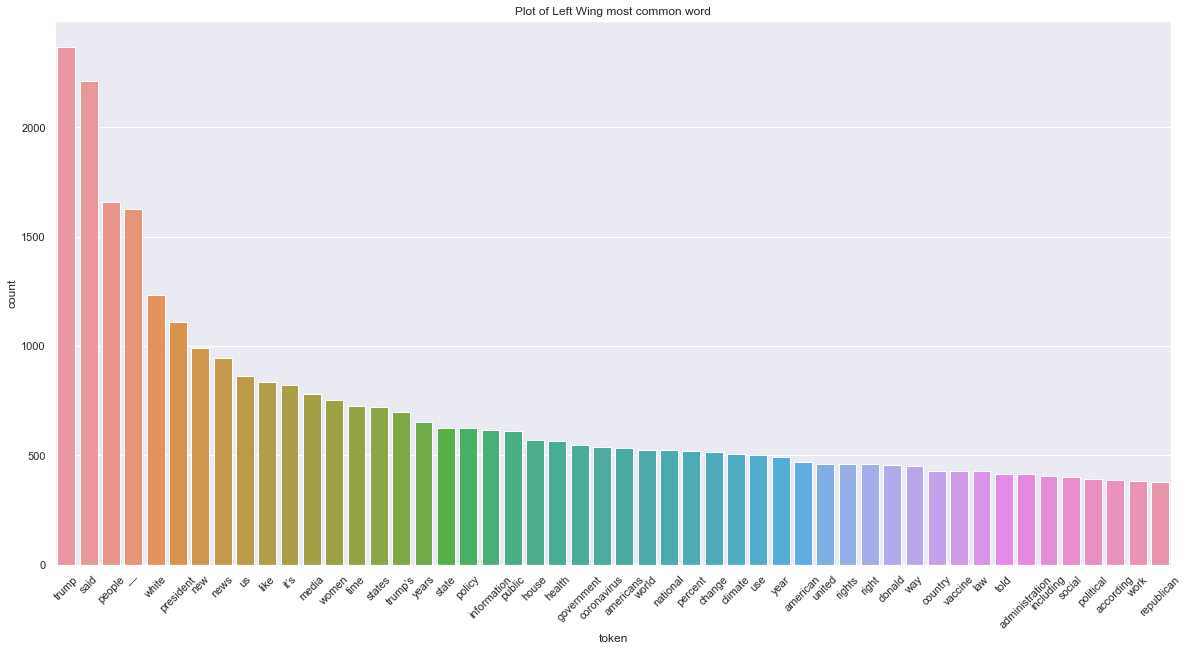

In [27]:
plot_most_common_word(left_kw,"Left Wing")

### Deep Learning 
+ TensorFlow
  - TextVectorizerlayer

In [28]:
# Creating a dictionary for the catergorical labels, i.e Center, Left, Right 

label_dict = {v:k for k,v in enumerate(data["type"].unique())}
print(label_dict)

{'center': 0, 'left': 1, 'right': 2}


In [29]:
# Separating the features and Labels 

features = data["clean_text"]
labels = data["type"].map(label_dict)

In [30]:
# Splitting the dataset for trainig and testing 

Xtrain,Xtest,Ytrain,Ytest = train_test_split(features, labels, test_size=0.30, random_state=42)

In [31]:
print(features.shape,Xtrain.shape,Ytrain.shape)
print(labels.shape,Ytest.shape,Ytest.shape)

(1700,) (1190,) (1190,)
(1700,) (510,) (510,)


**Feature Engineering Using Kearas**  

In [32]:
?? keras.layers.TextVectorization

In [33]:
text_vectorizer = keras.layers.TextVectorization(max_tokens=4000, standardize="lower_and_strip_punctuation", 
                                                 split="whitespace", output_mode="count")

In [34]:
# Creating Vectors from the data using Adapt and fittig the training data

text_vectorizer.adapt(Xtrain,batch_size=512)

In [35]:
# Vocab 

Vocab = text_vectorizer.get_vocabulary()

print(Vocab)

['[UNK]', 'said', 'trump', 'people', '—', 'president', 'white', 'new', 'us', 'like', 'news', 'state', 'it’s', 'states', 'house', 'years', 'american', 'media', 'women', 'percent', 'time', 'americans', 'health', 'government', 'public', 'democrats', 'trump’s', 'coronavirus', 'national', 'abortion', 'year', 'united', 'law', 'country', 'children', 'world', 'right', 'vaccine', 'gun', 'policy', 'tax', 'change', 'climate', 'rights', 'political', 'federal', 'student', 'way', 'donald', 'according', 'including', 'use', 'told', '–', 'social', 'million', 'support', 'it', 'don’t', '“the', 'debt', 'want', 'think', 'bill', 'campaign', '2020', 'week', 'going', 'work', 'biden', 'republican', 'york', 'group', 'need', 'information', 'vaccines', 'administration', 'republicans', 'democratic', 'life', 'college', 'immigration', 'court', 'border', 'number', 'security', 'groups', 'that’s', 'know', 'times', 'washington', 'sanders', 'parents', 'plan', 'left', 'economic', 'america', 'students', 'day', 'control', '

In [36]:
# Class Target 

classes = np.unique(Ytrain)
print(classes)

[0 1 2]


***Model Building*** 

In [37]:
# Creating a function to build the model pipeline 

def create_model (text_vectorizer):
    dl_model = Sequential([
        layers.Input(shape=(1,),dtype="string"),text_vectorizer,
        layers.Dense(128,activation="relu"),
        layers.Dense(64,activation="relu"),
        layers.Dense(len(classes),activation="softmax")
    ])
    return dl_model

**Model Creation** 


In [38]:
# calling the creation function above 

model = create_model(text_vectorizer)

In [39]:
# Model Summary 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 4000)             0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 128)               512128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 520,579
Trainable params: 520,579
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Model Compilation 

model.compile("adam","sparse_categorical_crossentropy",metrics=["accuracy"])

In [41]:
# Model Training 

history = model.fit(Xtrain,Ytrain,batch_size=250, epochs=10,validation_data=(Xtest,Ytest))

Epoch 1/10
5/5 [==============================] - 2s 236ms/step - loss: 1.3775 - accuracy: 0.4294 - val_loss: 1.0354 - val_accuracy: 0.6020
Epoch 2/10
5/5 [==============================] - 1s 110ms/step - loss: 0.8534 - accuracy: 0.7168 - val_loss: 0.8486 - val_accuracy: 0.7118
Epoch 3/10
5/5 [==============================] - 1s 132ms/step - loss: 0.5999 - accuracy: 0.8227 - val_loss: 0.6077 - val_accuracy: 0.7980
Epoch 4/10
5/5 [==============================] - 1s 130ms/step - loss: 0.4141 - accuracy: 0.9193 - val_loss: 0.5059 - val_accuracy: 0.8294
Epoch 5/10
5/5 [==============================] - 1s 114ms/step - loss: 0.2857 - accuracy: 0.9445 - val_loss: 0.4675 - val_accuracy: 0.8412
Epoch 6/10
5/5 [==============================] - 0s 90ms/step - loss: 0.1919 - accuracy: 0.9714 - val_loss: 0.4054 - val_accuracy: 0.8549
Epoch 7/10
5/5 [==============================] - 0s 88ms/step - loss: 0.1285 - accuracy: 0.9849 - val_loss: 0.4061 - val_accuracy: 0.8667
Epoch 8/10
5/5 [======

In [42]:
# Accuracy 

y_pred = model.predict(Xtest)

16/16 [==============================] - 0s 10ms/step


In [43]:
print(y_pred)

[[1.0604644e-01 6.8708919e-03 8.8708270e-01]
 [2.4589019e-07 9.9919456e-01 8.0516952e-04]
 [7.2231003e-08 1.6023485e-05 9.9998391e-01]
 ...
 [5.3087017e-04 1.9124052e-05 9.9945003e-01]
 [5.2683067e-01 1.7172982e-01 3.0143943e-01]
 [3.3444740e-05 9.9777114e-01 2.1954437e-03]]


# Model Evaluation

In [44]:
print(classification_report(Ytest,np.argmax(y_pred,axis=1),target_names=label_dict.keys()))

              precision    recall  f1-score   support

      center       0.80      0.73      0.77        94
        left       0.93      0.90      0.91       211
       right       0.85      0.91      0.88       205

    accuracy                           0.87       510
   macro avg       0.86      0.85      0.85       510
weighted avg       0.87      0.87      0.87       510



In [45]:
# Making a prediction 

pred = model.predict(np.array(Xtest.iloc[100]).reshape(1,-1))
result = np.argmax(pred,axis=1)

if result == 0:
    print("Center Wing")
elif result == 1:
    print("Left wing")
else:
    print("Right Wing")

1/1 [==============================] - 0s 31ms/step
Center Wing


In [46]:
pred = model.predict(np.array(Xtest.iloc[500]).reshape(1,-1))
result = np.argmax(pred,axis=1)

if result == 0:
    print("Center Wing")
elif result == 1:
    print("Left wing")
else:
    print("Right Wing")

1/1 [==============================] - 0s 24ms/step
Right Wing


In [47]:
pred = model.predict(np.array(Xtest.iloc[3]).reshape(1,-1))
result = np.argmax(pred,axis=1)

if result == 0:
    print("Center Wing")
elif result == 1:
    print("Left wing")
else:
    print("Right Wing")

1/1 [==============================] - 0s 26ms/step
Left wing


### Model Evaluation 


In [48]:
import shap

In [51]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(model,masker=masker,output_names=classes)
                    

In [55]:
explainer

In [59]:
example_1 = """ Teenage girl dies after being found in Warrington park with injuries
             A seriously injured teenage girl has died at a park in Warrington. 
             Emergency services called but she was declared dead at the scene. 
             Police say they do not believe there is a wider threat to anyone else.
             Police investigating her death are aware of the rumours online and 
             asked people not to speculate."""

shap_values = explainer([example_1])


In [60]:
shap_values

.values =
array([[[-3.88903171e-03, -1.22677488e-03,  5.11580147e-03],
        [-3.88903171e-03, -1.22677488e-03,  5.11580147e-03],
        [-1.00411149e-02, -8.53684265e-04,  1.08947931e-02],
        [-9.59876087e-03,  3.05726659e-04,  9.29303374e-03],
        [-8.07237020e-03,  5.46661951e-03,  2.60575139e-03],
        [-8.07237020e-03,  5.46661951e-03,  2.60575139e-03],
        [-1.69573119e-03,  8.25496577e-03, -6.55923435e-03],
        [-1.69573119e-03,  8.25496577e-03, -6.55923435e-03],
        [-9.05565498e-03, -8.70853042e-04,  9.92650601e-03],
        [-9.05565498e-03, -8.70853042e-04,  9.92650601e-03],
        [-1.62848150e-02,  1.77614863e-02, -1.47667465e-03],
        [-1.58137726e-02,  1.61945336e-02, -3.80754471e-04],
        [-1.58137726e-02,  1.61945336e-02, -3.80754471e-04],
        [ 2.66293064e-05,  6.16509095e-03, -6.19170908e-03],
        [ 2.66293064e-05,  6.16509095e-03, -6.19170908e-03],
        [-9.74155311e-03, -1.32439518e-03,  1.10659346e-02],
        [-9.74

### Interpretation 

In [61]:
shap.plots.text(shap_values)

In [64]:
example_2 = """ Russia says NATO should hold emergency summit over Nord Stream blasts
                Russian Foreign Ministry spokeswoman Maria Zakharova says NATO should 
                hold an emergency meeting to discuss recent findings about the Nord 
                Stream gas pipelines. The White House dismissed as "utterly false and
                complete fiction" the claim that the United States was behind explosions.
                Sweden and Denmark,in whose exclusive economic zones the blasts occurred,
                have concluded the pipelines were blown up deliberately."""

sharp_values = explainer([example_2])

In [65]:
shap.plots.text(shap_values)

**Thank You!**  
**Olatunde**